# Classification Modeling - Update

# Imports

In [1]:
from joblib import parallel_backend
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics

from sklearnex import patch_sklearn
patch_sklearn()

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers import Winsorizer

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf

set_config(transform_output='pandas')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Select Features

In [2]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)
    
for k, v in data.items():
    print(k, v)

booking_details ['UUID', 'HotelNumber', 'Adults', 'Children', 'Babies', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'ADR']
post_stay_details ['UUID', 'AssignedRoomType', 'BookingChanges', 'DaysInWaitingList', 'RequiredCarParkingSpaces', 'ReservationStatus']
reservation_specific ['UUID', 'Meal', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled']
temporal_features ['UUID', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'ReservationStatusDate']
new_temporal_features ['ArrivalDateDayName', 'ArrivalDateMonthName', 'ArrivalDate_DaysAfterHoliday', 'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'BookingDate_DaysAfterHoliday', 'BookingDate_DaysBeforeHoliday', 'DaysSinceBooking', 'DepartureDate_DaysAfterHoliday', 'DepartureDate_DaysBeforeHoliday', 'Length of Stay']


In [3]:
selected_features = data['booking_details']
selected_features.extend(data['post_stay_details'])
selected_features.extend(data['new_temporal_features'])
selected_features = set(selected_features)
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features.remove('AssignedRoomType')
selected_features.remove('RequiredCarParkingSpaces')
selected_features = list(selected_features)
selected_features.sort()

In [4]:
selected_features

['Adults',
 'Agent',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'Babies',
 'BookingChanges',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'Children',
 'Company',
 'Country',
 'CustomerType',
 'DaysInWaitingList',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepositType',
 'DistributionChannel',
 'HotelNumber',
 'Length of Stay',
 'MarketSegment',
 'ReservationStatus',
 'ReservedRoomType']

# Load Data

In [5]:
# df_data = pd.read_feather('../../data/2.3_data_with_occupancies.feather', columns=selected_features)
df_data = pd.read_feather('../../data/3.3_data_exploded.feather', columns=selected_features)
df_data

,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,ReservedRoomType,BookingChanges,DepositType,Agent,...,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalWeek,ArrivalDay,ArrivalDateDayName,ArrivalDateMonthName
0,1,0.0,0,PRT,Offline TA/TO,TA/TO,A,0,No Deposit,6,...,45,21,43,23,51,15,27,3,Wednesday,July
1,1,0.0,0,None,Online TA,TA/TO,A,0,No Deposit,240,...,45,21,44,22,47,19,27,3,Wednesday,July
2,2,0.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,156,...,45,21,38,28,60,32,27,3,Wednesday,July
3,1,0.0,0,None,Direct,Direct,A,2,No Deposit,NULL,...,45,21,31,35,29,63,27,3,Wednesday,July
4,2,0.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,253,...,45,21,41,25,37,55,27,3,Wednesday,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409252,2,0.0,0,IRL,Direct,Direct,E,0,No Deposit,250,...,37,14,23,28,67,36,35,2,Tuesday,August
409253,2,0.0,0,DEU,Offline TA/TO,TA/TO,A,0,No Deposit,69,...,35,16,21,30,22,81,35,4,Thursday,August
409254,2,0.0,0,GBR,Offline TA/TO,TA/TO,D,0,No Deposit,40,...,35,16,21,30,72,31,35,4,Thursday,August
409255,2,0.0,0,DEU,Offline TA/TO,TA/TO,A,0,No Deposit,69,...,35,16,21,30,22,81,35,4,Thursday,August


In [6]:
df_data[selected_features]

,Adults,Agent,ArrivalDateDayName,ArrivalDateMonthName,ArrivalDate_DaysAfterHoliday,ArrivalDate_DaysBeforeHoliday,ArrivalDay,ArrivalWeek,Babies,BookingChanges,...,DaysSinceBooking,DepartureDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepositType,DistributionChannel,HotelNumber,Length of Stay,MarketSegment,ReservationStatus,ReservedRoomType
0,1,6,Wednesday,July,21,45,3,27,0,0,...,8,23,43,No Deposit,TA/TO,H2,2,Offline TA/TO,Check-Out,A
1,1,240,Wednesday,July,21,45,3,27,0,0,...,3,22,44,No Deposit,TA/TO,H1,1,Online TA,Check-Out,A
2,2,156,Wednesday,July,21,45,3,27,0,0,...,156,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
3,1,NULL,Wednesday,July,21,45,3,27,0,2,...,132,35,31,No Deposit,Direct,H1,14,Direct,Check-Out,A
4,2,253,Wednesday,July,21,45,3,27,0,0,...,130,25,41,No Deposit,TA/TO,H1,4,Offline TA/TO,Check-Out,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409252,2,250,Tuesday,August,14,37,2,35,0,0,...,218,28,23,No Deposit,Direct,H1,14,Direct,Check-Out,E
409253,2,69,Thursday,August,16,35,4,35,0,0,...,175,30,21,No Deposit,TA/TO,H1,14,Offline TA/TO,Check-Out,A
409254,2,40,Thursday,August,16,35,4,35,0,0,...,225,30,21,No Deposit,TA/TO,H1,14,Offline TA/TO,Check-Out,D
409255,2,69,Thursday,August,16,35,4,35,0,0,...,175,30,21,No Deposit,TA/TO,H1,14,Offline TA/TO,Check-Out,A


## Transform Target

In [7]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show', 'Canceled', df_data['ReservationStatus'])
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

# Train/Test Split

In [8]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903, stratify=y)

In [9]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

In [10]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

# Random Forest Classifer Model Without Tuning

In [11]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##


# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=15))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'Children', 'DaysInWaitingList',
       'DaysSinceBooking', 'DepartureDate_DaysA...
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=15,
                                                                sparse_output=False))]),
                                 Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])

In [12]:
X_train_xf = preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
238714,2.0,3.0,27.0,5.0,44.0,0.0,0.0,3.0,81.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117578,2.0,22.0,7.0,1.0,16.0,0.0,0.0,79.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340847,2.0,21.0,19.0,1.0,21.0,0.0,0.0,1.0,5.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42882,2.0,48.0,67.0,5.0,40.0,0.0,0.0,30.0,85.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281656,2.0,43.0,60.0,1.0,7.0,0.0,0.0,37.0,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252439,3.0,4.0,3.0,1.0,49.0,0.0,0.0,39.0,12.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
222113,1.0,5.0,22.0,1.0,41.0,0.0,0.0,46.0,20.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387736,0.0,46.0,15.0,1.0,31.0,0.0,1.0,52.0,51.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163141,2.0,27.0,39.0,4.0,27.0,0.0,0.0,17.0,49.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
for col in X_train_xf.columns:
    print(col)

num__Adults
num__ArrivalDate_DaysAfterHoliday
num__ArrivalDate_DaysBeforeHoliday
num__ArrivalDay
num__ArrivalWeek
num__Babies
num__BookingChanges
num__BookingDate_DaysAfterHoliday
num__BookingDate_DaysBeforeHoliday
num__Children
num__DaysInWaitingList
num__DaysSinceBooking
num__DepartureDate_DaysAfterHoliday
num__DepartureDate_DaysBeforeHoliday
num__Length of Stay
cat__Agent_          1
cat__Agent_          6
cat__Agent_          7
cat__Agent_          8
cat__Agent_          9
cat__Agent_         14
cat__Agent_         28
cat__Agent_         40
cat__Agent_        240
cat__Agent_        241
cat__Agent_        243
cat__Agent_        250
cat__Agent_        314
cat__Agent_       NULL
cat__Agent_infrequent_sklearn
cat__Company_         40
cat__Company_         45
cat__Company_         51
cat__Company_         67
cat__Company_        153
cat__Company_        154
cat__Company_        174
cat__Company_        223
cat__Company_        233
cat__Company_        242
cat__Company_        281
cat__C

In [14]:
## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced'))])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):

    ## --- Fit the model and generate predictions --- ##
    model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

## Model Results

### Scoring


Training Score: 1.000
Testing Score: 0.993
Difference: 0.007

              precision    recall  f1-score   support

    Canceled       1.00      0.98      0.99     38555
   Check-Out       0.99      1.00      0.99     63760

    accuracy                           0.99    102315
   macro avg       0.99      0.99      0.99    102315
weighted avg       0.99      0.99      0.99    102315



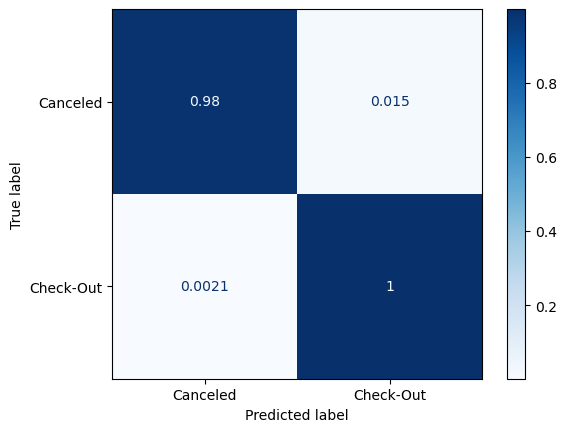

In [15]:
print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

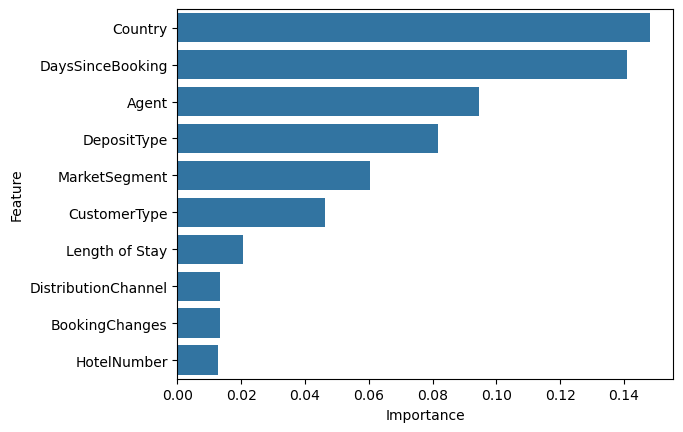

In [16]:
# Calculate permutation importances
result = permutation_importance(model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

### Tree Depths

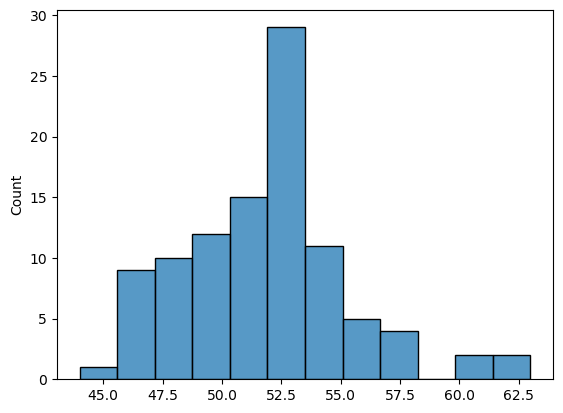

In [17]:
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [18]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=15))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])


# Create the RandomForestClassifier model
classifier = RandomForestClassifier(class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'classifier__max_depth': [40,45,50]}

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    grid_search = GridSearchCV(model_pipeline,
                               param_grid,
                               scoring='f1',
                               cv=stratified_kfold)

    # Fit the model and generate predictions
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


## RFC Model w/ Tuning Results

### Scoring


Training Score: 1.000
Testing Score: 0.993
Difference: 0.007

              precision    recall  f1-score   support

    Canceled       1.00      0.98      0.99     38555
   Check-Out       0.99      1.00      0.99     63760

    accuracy                           0.99    102315
   macro avg       0.99      0.99      0.99    102315
weighted avg       0.99      0.99      0.99    102315



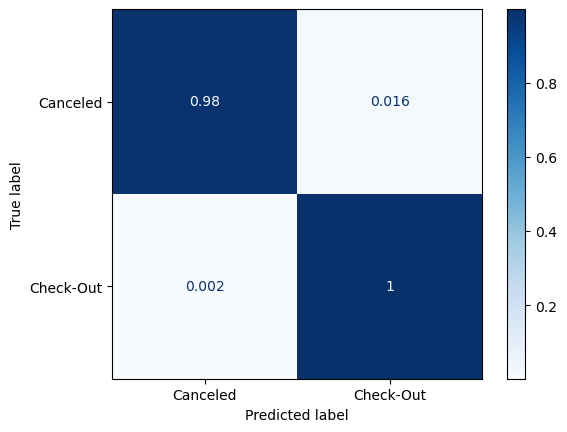

In [19]:
print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

In [20]:
metrics.f1_score(y_test, y_pred, average='weighted').round(2)

0.99

### Permutation Importances

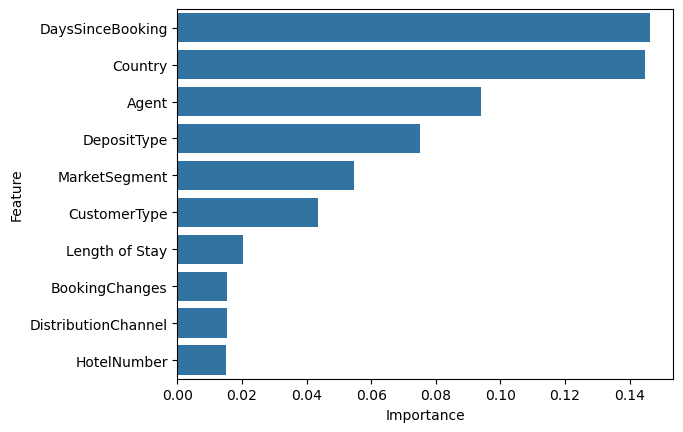

In [21]:
# Calculate permutation importances
result = permutation_importance(best_model,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - RFC

In [22]:
# X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
# X_train_xf

In [23]:
# X_shap = shap.sample(X_train_xf, 500)
# X_shap

In [24]:
# y_shap = y_train.loc[X_shap.index]
# y_shap

In [25]:
# explainer = shap.Explainer(best_model.named_steps.classifier, X_shap)
# shap_values = explainer(X_shap)
# shap_values.shape

### Summary Plot

In [26]:
# shap.summary_plot(shap_values[:, :, 0], X_shap)

In [27]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [28]:
# # For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [29]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=15))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])


# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)


Training Score: 0.897
Testing Score: 0.895
Difference: 0.002

              precision    recall  f1-score   support

    Canceled       0.85      0.88      0.86     38555
   Check-Out       0.92      0.91      0.91     63760

    accuracy                           0.89    102315
   macro avg       0.89      0.89      0.89    102315
weighted avg       0.90      0.89      0.90    102315



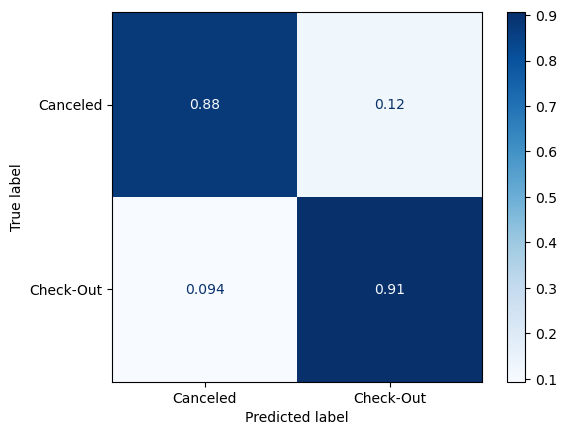

In [30]:
print(f'\nTraining Score: {hgbr_score_training:,.3f}\n'
      f'Testing Score: {hgbr_score_testing:,.3f}\n'
      f'Difference: {hgbr_score_training - hgbr_score_testing:,.3f}\n')

print(classification_report(y_test, hgbr_y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, hgbr_y_pred, cmap='Blues', normalize='true');

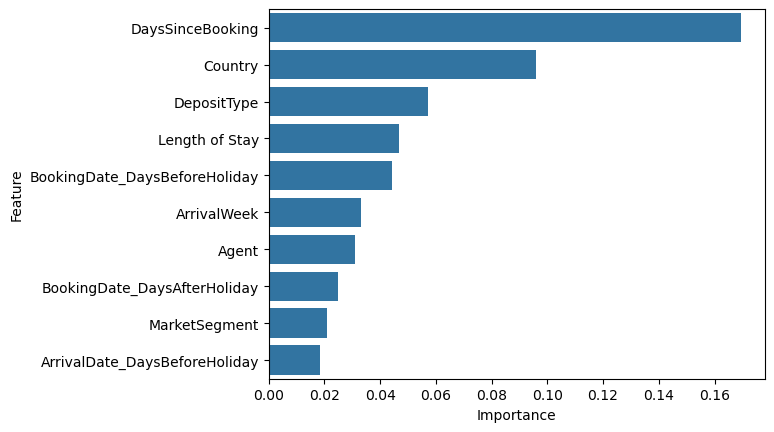

In [31]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [32]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
238714,2.0,3.0,27.0,5.0,44.0,0.0,0.0,3.0,81.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117578,2.0,22.0,7.0,1.0,16.0,0.0,0.0,79.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340847,2.0,21.0,19.0,1.0,21.0,0.0,0.0,1.0,5.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42882,2.0,48.0,67.0,5.0,40.0,0.0,0.0,30.0,85.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281656,2.0,43.0,60.0,1.0,7.0,0.0,0.0,37.0,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252439,3.0,4.0,3.0,1.0,49.0,0.0,0.0,39.0,12.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
222113,1.0,5.0,22.0,1.0,41.0,0.0,0.0,46.0,20.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387736,0.0,46.0,15.0,1.0,31.0,0.0,1.0,52.0,51.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163141,2.0,27.0,39.0,4.0,27.0,0.0,0.0,17.0,49.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X_shap = shap.sample(X_train_xf, 500)
X_shap

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
272531,2.0,24.0,79.0,3.0,4.0,0.0,0.0,5.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17205,2.0,62.0,4.0,2.0,33.0,0.0,0.0,28.0,38.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
406707,2.0,14.0,37.0,2.0,35.0,0.0,0.0,34.0,27.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91690,1.0,61.0,23.0,3.0,9.0,0.0,0.0,61.0,23.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197484,2.0,14.0,37.0,1.0,35.0,0.0,0.0,36.0,30.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233173,2.0,14.0,13.0,3.0,42.0,0.0,1.0,5.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
377792,2.0,24.0,37.0,7.0,27.0,0.0,0.0,36.0,67.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128121,2.0,7.0,18.0,7.0,18.0,0.0,1.0,51.0,33.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329822,2.0,2.0,38.0,3.0,18.0,0.0,0.0,27.0,76.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y_shap = y_train.loc[X_shap.index]
y_shap

272531    Check-Out
17205      Canceled
406707    Check-Out
91690     Check-Out
197484    Check-Out
            ...    
233173    Check-Out
377792    Check-Out
128121    Check-Out
329822    Check-Out
91869     Check-Out
Name: ReservationStatus, Length: 500, dtype: object

In [35]:
hgbr_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'Children', 'DaysInWaitingList',
       'DaysSi...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=15,
                                                                                 sparse_output=False))]),
                                                  Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced'))])

In [39]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

(500, 92)

## Summary Plot

In [40]:
shap.summary_plot(shap_values[:, :, 0], X_shap)

IndexError: too many indices for array

In [ ]:
df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']